# load library

In [1]:
import numpy as np; np.random.seed(2020)
import pandas as pd; pd.options.display.float_format='{:.1f}'.format
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white',context='talk')
import datetime as dt

In [2]:
data=pd.read_csv('../input/online-retail-data-v3/RetailDataIII.csv')
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Bill,MerchandiseID,Product,Quota,BillDate,Amount,CustomerID,Country
0,532657,21314,Small glass heart trinket pot,12,2018-11-14,4.1,14562.0,United Kingdom
1,563214,22383,Lunch bag suki design,2,2019-8-14,3.6,16370.0,United Kingdom
2,507597,22561,Wooden school colouring set,12,2018-5-10,3.6,17700.0,United Kingdom
3,491634,21588,Retro spot giant tube matches,1,2017-12-11,4.5,17841.0,United Kingdom
4,496007,85232B,Set/3 russian doll stacking tins,3,2018-1-28,7.0,15203.0,United Kingdom


# data info

In [3]:
def datainfo(data):
    return pd.DataFrame([(col,data[col].nunique(),data[col].isna().sum(),data[col].dtype,
                         data[col].unique()[:5]) for col in data.columns],
                        columns=['name','nunique','missing','dtype','value :5'])

datainfo(data)

,name,nunique,missing,dtype,value :5
0,Bill,89998,0,object,"[532657, 563214, 507597, 491634, 496007]"
1,MerchandiseID,5305,0,object,"[21314, 22383, 22561, 21588, 85232B]"
2,Product,5675,4382,object,"[Small glass heart trinket pot, Lunch bag suki..."
3,Quota,1057,0,int64,"[12, 2, 1, 3, 4]"
4,BillDate,604,0,object,"[2018-11-14, 2019-8-14, 2018-5-10, 2017-12-11,..."
5,Amount,2807,0,float64,"[4.1, 3.65, 4.55, 6.95, 4.95]"
6,CustomerID,5942,243007,float64,"[14562.0, 16370.0, 17700.0, 17841.0, 15203.0]"
7,Country,43,0,object,"[United Kingdom, Germany, France, Sweden, EIRE]"


* drop missing value in subset-customerid 
* change dtype object to datetime

In [4]:
data['BillDate']=pd.to_datetime(data['BillDate'])
data.dropna(subset=['CustomerID'],inplace=True)

In [5]:
data.describe()

,Quota,Amount,CustomerID
count,824364.0,824364.0,824364.0
mean,12.4,5.7,15324.6
std,189.0,70.2,1697.5
min,-80995.0,2.0,12346.0
25%,2.0,3.2,13975.0
50%,5.0,4.0,15255.0
75%,12.0,5.8,16797.0
max,80995.0,38972.0,18287.0


* drop neg Quota

In [6]:
data=data[data['Quota']>0]

* format billdate > %year, %month, 1

In [9]:
def get_month(day):
    return dt.datetime(day.year,day.month,1)

data['billmonth']=data['BillDate'].apply(get_month)
data['cohortmonth']=data.groupby('CustomerID')['billmonth'].transform(min)

* i need cohortindex

In [13]:
def get_year_month(df,col):
    year=df[col].apply(lambda day:day.year)
    month=df[col].apply(lambda day:day.month)
    return year,month

bill_year,bill_month=get_year_month(data,'billmonth')
cohort_year,cohort_month=get_year_month(data,'cohortmonth')
diff_year=bill_year-cohort_year
diff_month=bill_month-cohort_month

data['cohortindex']=diff_year*12+diff_month+1

* get cohort data

In [16]:
cohortdata=data.groupby(['cohortindex','cohortmonth'])['CustomerID'].apply(pd.Series.nunique)
cohortdata=cohortdata.reset_index()

In [18]:
cohort_pivot=cohortdata.pivot(index='cohortmonth',columns='cohortindex',values='CustomerID')

* retention rate

In [19]:
retention=cohort_pivot.divide(cohort_pivot[1],axis=0)

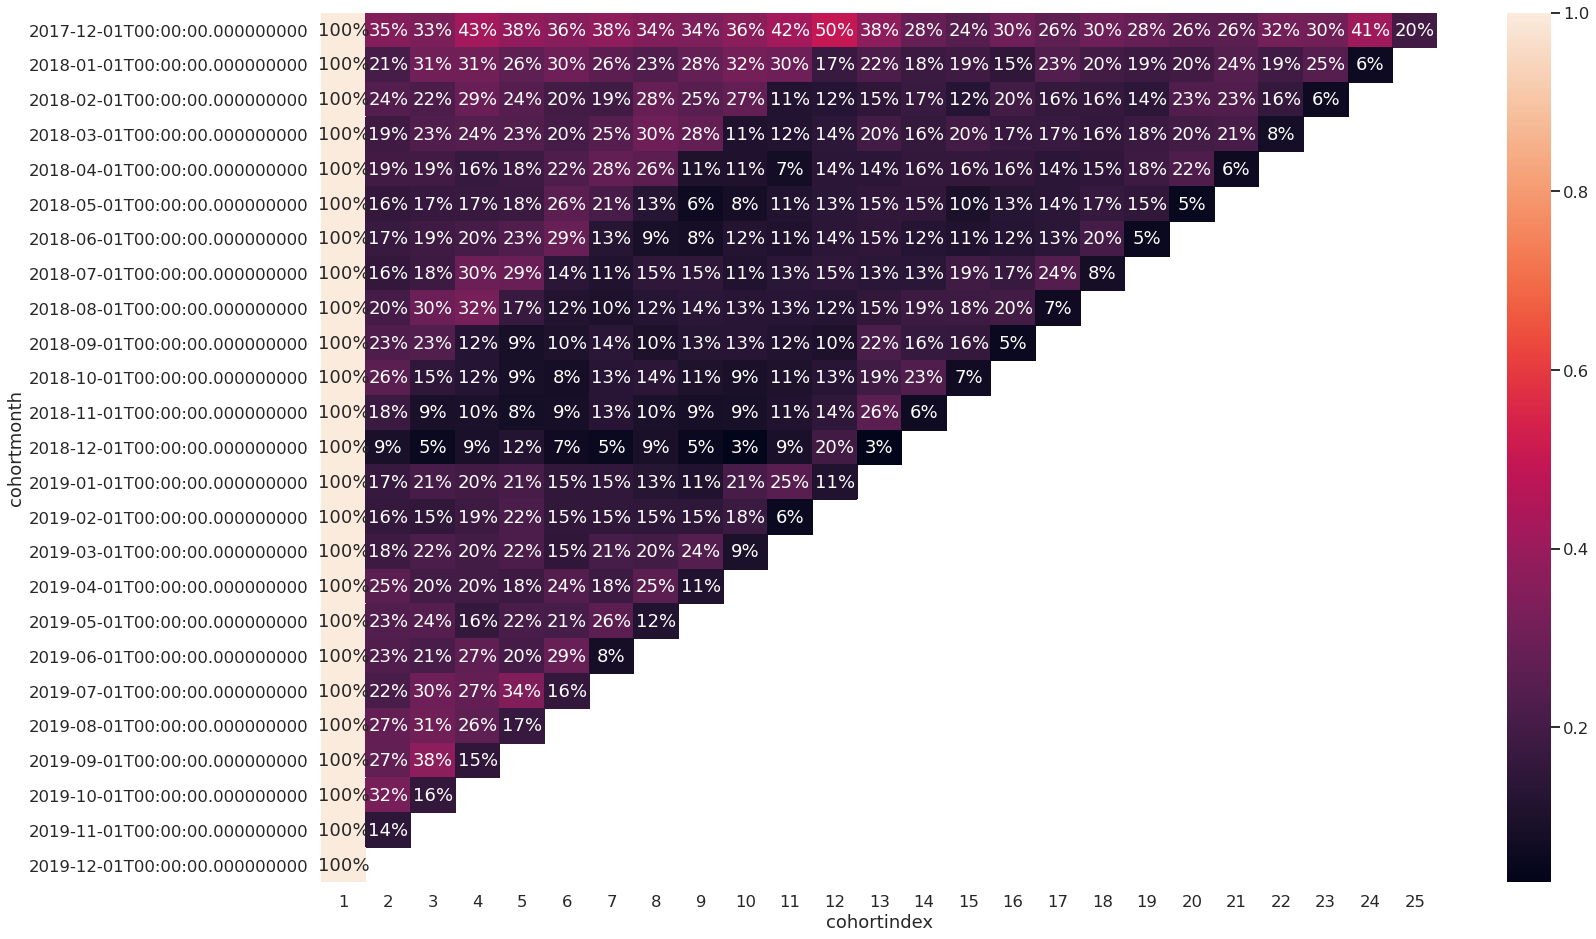

In [23]:
plt.figure(figsize=(25,16))
sns.heatmap(data=retention,annot=True,fmt='.0%')
plt.show()

# RFM

In [29]:
data

,Bill,MerchandiseID,Product,Quota,BillDate,Amount,CustomerID,Country,billmonth,cohortmonth,cohortindex
0,532657,21314,Small glass heart trinket pot,12,2018-11-14,4.1,14562.0,United Kingdom,2018-11-01,2018-02-01,10
1,563214,22383,Lunch bag suki design,2,2019-08-14,3.6,16370.0,United Kingdom,2019-08-01,2019-04-01,5
2,507597,22561,Wooden school colouring set,12,2018-05-10,3.6,17700.0,United Kingdom,2018-05-01,2017-12-01,6
3,491634,21588,Retro spot giant tube matches,1,2017-12-11,4.5,17841.0,United Kingdom,2017-12-01,2017-12-01,1
4,496007,85232B,Set/3 russian doll stacking tins,3,2018-01-28,7.0,15203.0,United Kingdom,2018-01-01,2017-12-01,2
...,...,...,...,...,...,...,...,...,...,...,...
1067364,502588,22423,Regency cakestand 3 tier,1,2018-03-25,14.8,16550.0,United Kingdom,2018-03-01,2017-12-01,4
1067366,499973,21529,Retro spot ceramic toastrack,1,2018-03-03,5.5,13595.0,United Kingdom,2018-03-01,2018-03-01,1
1067367,514387,21980,Pack of 12 red spotty tissues,48,2018-07-02,2.3,12633.0,Germany,2018-07-01,2018-07-01,1
1067368,501897,22268,Easter decoration sitting bunny,10,2018-03-21,2.9,17539.0,United Kingdom,2018-03-01,2017-12-01,4


In [38]:
data['total']=data['Quota']*data['Amount'] 
max_time=max(data['BillDate'])+dt.timedelta(days=1)

rfm=data.groupby('CustomerID').agg({'BillDate': lambda day:(max_time-max(day)).days,
                                   'Bill':'count',
                                   'total':'sum'})
rfm.rename(columns={'BillDate':'recently',
                        'Bill':'frequency',
                        'total':'money'},inplace=True)

In [42]:
rfm['R']=pd.qcut(rfm['recently'],q=4,labels=range(4,0,-1))
rfm['F']=pd.qcut(rfm['frequency'],q=4,labels=range(1,5,1))
rfm['M']=pd.qcut(rfm['money'],q=4,labels=range(1,5,1))

def get_rfm(rfm):
    return str(rfm['R'])+str(rfm['F'])+str(rfm['M'])
rfm['RFMsegment']=rfm.apply(get_rfm,axis=1)
rfm['score']=rfm[['R','F','M']].sum(axis=1)

# analyze rfm

In [61]:
rfm.groupby('RFMsegment').size().sort_values(ascending=False)[:5]

RFMsegment
444    618
111    568
344    331
211    285
333    243
dtype: int64

In [65]:
rfm.groupby('RFMsegment').agg({'recently': 'mean','frequency': 'mean',
                             'money': ['mean', 'count'] })

recently frequency   money      
               mean      mean    mean count
RFMsegment                                 
111           542.7       9.8   362.7   568
112           533.4      13.1  1067.0   122
113           524.9       9.5  2835.9    20
114           517.5       7.5 14588.2    11
121           529.5      34.5   443.5   150
122           499.7      34.1  1204.6   238
123           473.4      39.0  2652.3    53
124           504.4      36.0 25762.2    12
131           483.6      67.8   575.7    31
132           469.7      79.7  1219.7    68
133           457.4      82.6  3086.2   116
134           501.6      82.7 30935.6    20
142           466.7     180.7  1474.9     9
143           457.8     220.9  3350.5    32
144           460.3     329.0 14729.4    19
211           239.8      10.1   387.7   285
212           226.2      13.3  1101.7    95
213           204.5      10.4  3034.7    21
214           169.9      10.5 15573.9    14
221           244.3      32.0   484.0    73
222           239.2      34.6  1243.4   241
223           227.0      39.9  2681.7    91
224           200.0      41.0 27891.9    12
231           247.4      73.7   596.7    18
232           246.6      87.5  1299.7   107
233           218.5      84.3  3110.4   239
234           186.1     101.8 14102.9    63
242           273.1     167.2  1516.9    12
243           216.2     250.6  3433.2    69
244           196.4     343.9 12731.5   124
311            56.8      10.7   412.2   162
312            61.9      14.9  1139.8    54
313            59.5      11.2  3079.4    20
314            64.0      13.8 17802.3     8
321            56.2      32.3   522.8    44
322            58.6      34.3  1297.7   184
323            57.3      40.7  2866.2    92
324            59.3      40.8 20944.7    19
331            54.0      73.3   587.3    12
332            50.9      81.7  1343.7    77
333            55.8      89.1  3317.5   243
334            61.8     105.5  9948.8    96
342            43.9     182.6  1496.8    17
343            49.9     251.1  3548.9   101
344            50.5     334.4 13522.6   331
411            15.0      10.4   476.3    95
412            15.7      15.1  1087.8    40
413            14.3      13.1  3031.5    13
414             8.0       4.0 79734.8     5
421            13.6      33.6   526.6    25
422            13.2      37.0  1325.3   113
423            14.1      42.5  2628.2    51
424            10.1      38.5 11729.5    23
431            13.2      74.9   602.9     8
432            14.7      92.6  1371.4    73
433            13.4      86.2  3225.4   192
434            12.7     109.3 11231.3    95
442            16.4     177.0  1544.6    20
443            12.5     267.8  3403.1   117
444            10.7     579.2 32401.0   618